# PsychohistoryML: Collapse Prediction Model

**Objective**: Build a binary classification model to predict whether a polity will collapse within a certain timeframe based on its social complexity profile.

## Research Questions
1. Can we predict polity collapse from complexity metrics?
2. Which features are most predictive of collapse risk?
3. What are the early warning signals in complexity trajectories?
4. How accurate can we be with limited historical data?

## Approach
- **Target Variable**: Binary collapse indicator (short duration vs. long duration)
- **Features**: PCA components, complexity metrics, temporal indicators
- **Models**: Logistic Regression → Random Forest → XGBoost
- **Evaluation**: Precision, Recall, ROC-AUC, confusion matrix
- **Class Imbalance**: SMOTE or class weights

## Definition of "Collapse"
For this analysis, we define collapse as polities with duration < median duration (rapid turnover).

---
## 1. Setup & Data Loading

In [14]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
from pathlib import Path
import warnings
warnings.filterwarnings('ignore')

# Classification models
from sklearn.model_selection import train_test_split, cross_val_score, GridSearchCV
from sklearn.linear_model import LogisticRegression
from sklearn.ensemble import RandomForestClassifier
from sklearn.metrics import (
    classification_report, confusion_matrix, roc_auc_score, 
    roc_curve, precision_recall_curve, auc
)
from sklearn.preprocessing import StandardScaler
from imblearn.over_sampling import SMOTE

# Importing XGBoost
try:
    from xgboost import XGBClassifier
    XGBOOST_AVAILABLE = True
except ImportError:
    print("⚠ XGBoost not installed. Run: pip install xgboost")
    XGBOOST_AVAILABLE = False

# Visualization
sns.set_style("whitegrid")
plt.rcParams['figure.figsize'] = (12, 6)
plt.rcParams['font.size'] = 11

# Create directories
Path("figures").mkdir(exist_ok=True)
Path("models").mkdir(exist_ok=True)

print("✓ Libraries loaded")
print(f"✓ XGBoost available: {XGBOOST_AVAILABLE}")

✓ Libraries loaded
✓ XGBoost available: True


### Load Processed Data from Notebook 02

In [2]:
# Load the modeling dataset from previous analysis
modeling_df = pd.read_csv("models/modeling_dataset.csv", index_col="PolityKey")

print(f"✓ Loaded {len(modeling_df)} polities")
print(f"  Features: {modeling_df.columns.tolist()}")
display(modeling_df.head())

✓ Loaded 114 polities
  Features: ['PC1_hier', 'PC2_hier', 'PC3_hier', 'start_year_est', 'end_year_est', 'NGA', 'Polity', 'duration_years', 'log_duration']


,PC1_hier,PC2_hier,PC3_hier,start_year_est,end_year_est,NGA,Polity,duration_years,log_duration
PolityKey,,,,,,,,,
Cahokia | FrBurbL,3.724407,0.477994,-1.136347,1650.0,1720.0,Cahokia,FrBurbL,70.0,4.248495
Cahokia | USIllin,-2.447330,0.115259,-0.349037,1600.0,1832.0,Cahokia,USIllin,232.0,5.446737
Cahokia | USMisME,-1.704575,0.721515,0.557793,900.0,1050.0,Cahokia,USMisME,150.0,5.010635
Cambodian Basin | ThAyuth,1.746726,1.347402,-0.404456,1596.0,1767.0,Cambodian Basin,ThAyuth,171.0,5.141664
Cambodian Basin | ThRattn,1.516812,1.445160,-0.133310,1782.0,1873.0,Cambodian Basin,ThRattn,91.0,4.510860


---
## 2. Create Binary Target Variable


=== TARGET VARIABLE DISTRIBUTION ===
Collapse threshold: 162 years

Class balance:
collapsed
0    62
1    52
Name: count, dtype: int64

Proportions:
collapsed
0    0.54386
1    0.45614
Name: proportion, dtype: float64


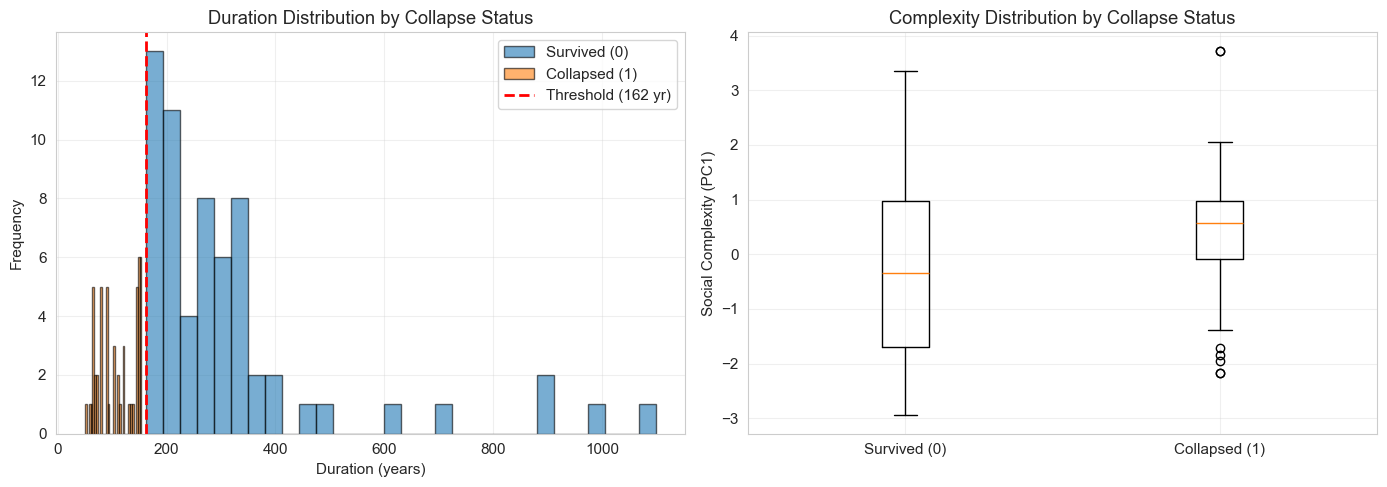


✓ Saved: figures/03_target_distribution.png


In [4]:
# Define collapse threshold (below median = high risk / early collapse)
duration_median = modeling_df['duration_years'].median()

# Create binary target: 1 = collapsed (short duration), 0 = survived (long duration)
modeling_df['collapsed'] = (modeling_df['duration_years'] < duration_median).astype(int)

print(f"\n=== TARGET VARIABLE DISTRIBUTION ===" )
print(f"Collapse threshold: {duration_median:.0f} years")
print(f"\nClass balance:")
print(modeling_df['collapsed'].value_counts())
print(f"\nProportions:")
print(modeling_df['collapsed'].value_counts(normalize=True))

# Visualize distribution
fig, axes = plt.subplots(1, 2, figsize=(14, 5))

# Duration distribution by collapse status
axes[0].hist(modeling_df[modeling_df['collapsed']==0]['duration_years'], 
             bins=30, alpha=0.6, label='Survived (0)', edgecolor='black')
axes[0].hist(modeling_df[modeling_df['collapsed']==1]['duration_years'], 
             bins=30, alpha=0.6, label='Collapsed (1)', edgecolor='black')
axes[0].axvline(duration_median, color='r', linestyle='--', linewidth=2, label=f'Threshold ({duration_median:.0f} yr)')
axes[0].set_xlabel("Duration (years)")
axes[0].set_ylabel("Frequency")
axes[0].set_title("Duration Distribution by Collapse Status")
axes[0].legend()
axes[0].grid(alpha=0.3)

# Complexity distribution by collapse status
axes[1].boxplot([modeling_df[modeling_df['collapsed']==0]['PC1_hier'],
                  modeling_df[modeling_df['collapsed']==1]['PC1_hier']],
                 labels=['Survived (0)', 'Collapsed (1)'])
axes[1].set_ylabel("Social Complexity (PC1)")
axes[1].set_title("Complexity Distribution by Collapse Status")
axes[1].grid(alpha=0.3)

plt.tight_layout()
plt.savefig("figures/03_target_distribution.png", dpi=300, bbox_inches="tight")
plt.show()
print("\n✓ Saved: figures/03_target_distribution.png")

---
## 3. Feature Engineering

In [5]:
# Select features for modeling
feature_cols = ['PC1_hier', 'PC2_hier', 'PC3_hier']

# Optional: Add interaction terms
modeling_df['PC1_squared'] = modeling_df['PC1_hier'] ** 2
modeling_df['PC1_x_PC2'] = modeling_df['PC1_hier'] * modeling_df['PC2_hier']
feature_cols.extend(['PC1_squared', 'PC1_x_PC2'])

print(f"✓ Feature set: {feature_cols}")
print(f"  Number of features: {len(feature_cols)}")

✓ Feature set: ['PC1_hier', 'PC2_hier', 'PC3_hier', 'PC1_squared', 'PC1_x_PC2']
  Number of features: 5


---
## 4. Train-Test Split

In [6]:
# Prepare features and target
X = modeling_df[feature_cols].values
y = modeling_df['collapsed'].values

# Split into train and test sets
X_train, X_test, y_train, y_test = train_test_split(
    X, y, test_size=0.2, random_state=42, stratify=y
)

# Standardize features
scaler = StandardScaler()
X_train_scaled = scaler.fit_transform(X_train)
X_test_scaled = scaler.transform(X_test)

print(f"\n=== DATA SPLIT ===" )
print(f"Training set: {X_train.shape[0]} samples")
print(f"Test set: {X_test.shape[0]} samples")
print(f"\nClass distribution in training set:")
print(pd.Series(y_train).value_counts())


=== DATA SPLIT ===
Training set: 91 samples
Test set: 23 samples

Class distribution in training set:
0    49
1    42
Name: count, dtype: int64


---
## 5. Baseline Model: Logistic Regression

In [7]:
# Train logistic regression
log_reg = LogisticRegression(random_state=42, max_iter=1000)
log_reg.fit(X_train_scaled, y_train)

# Predictions
y_pred_lr = log_reg.predict(X_test_scaled)
y_proba_lr = log_reg.predict_proba(X_test_scaled)[:, 1]

# Evaluate
print("\n" + "="*80)
print("LOGISTIC REGRESSION RESULTS")
print("="*80)
print("\nClassification Report:")
print(classification_report(y_test, y_pred_lr, target_names=['Survived', 'Collapsed']))

# ROC-AUC
roc_auc_lr = roc_auc_score(y_test, y_proba_lr)
print(f"\nROC-AUC Score: {roc_auc_lr:.3f}")

# Feature importance (coefficients)
feature_importance_lr = pd.DataFrame({
    'Feature': feature_cols,
    'Coefficient': log_reg.coef_[0]
}).sort_values('Coefficient', key=abs, ascending=False)

print("\nFeature Importance (Coefficients):")
display(feature_importance_lr)


LOGISTIC REGRESSION RESULTS

Classification Report:
              precision    recall  f1-score   support

    Survived       0.80      0.62      0.70        13
   Collapsed       0.62      0.80      0.70        10

    accuracy                           0.70        23
   macro avg       0.71      0.71      0.70        23
weighted avg       0.72      0.70      0.70        23


ROC-AUC Score: 0.746

Feature Importance (Coefficients):


,Feature,Coefficient
0,PC1_hier,0.496110
3,PC1_squared,-0.364310
1,PC2_hier,0.190482
2,PC3_hier,0.107214
4,PC1_x_PC2,-0.003374


---
## 6. Random Forest Classifier

In [8]:
# Train Random Forest
rf_clf = RandomForestClassifier(
    n_estimators=100,
    max_depth=5,
    min_samples_split=10,
    random_state=42,
    class_weight='balanced'  # Handle class imbalance
)
rf_clf.fit(X_train, y_train)

# Predictions
y_pred_rf = rf_clf.predict(X_test)
y_proba_rf = rf_clf.predict_proba(X_test)[:, 1]

# Evaluate
print("\n" + "="*80)
print("RANDOM FOREST RESULTS")
print("="*80)
print("\nClassification Report:")
print(classification_report(y_test, y_pred_rf, target_names=['Survived', 'Collapsed']))

# ROC-AUC
roc_auc_rf = roc_auc_score(y_test, y_proba_rf)
print(f"\nROC-AUC Score: {roc_auc_rf:.3f}")

# Feature importance
feature_importance_rf = pd.DataFrame({
    'Feature': feature_cols,
    'Importance': rf_clf.feature_importances_
}).sort_values('Importance', ascending=False)

print("\nFeature Importance:")
display(feature_importance_rf)


RANDOM FOREST RESULTS

Classification Report:
              precision    recall  f1-score   support

    Survived       0.85      0.85      0.85        13
   Collapsed       0.80      0.80      0.80        10

    accuracy                           0.83        23
   macro avg       0.82      0.82      0.82        23
weighted avg       0.83      0.83      0.83        23


ROC-AUC Score: 0.838

Feature Importance:


,Feature,Importance
3,PC1_squared,0.242808
0,PC1_hier,0.241309
4,PC1_x_PC2,0.184418
1,PC2_hier,0.167223
2,PC3_hier,0.164241


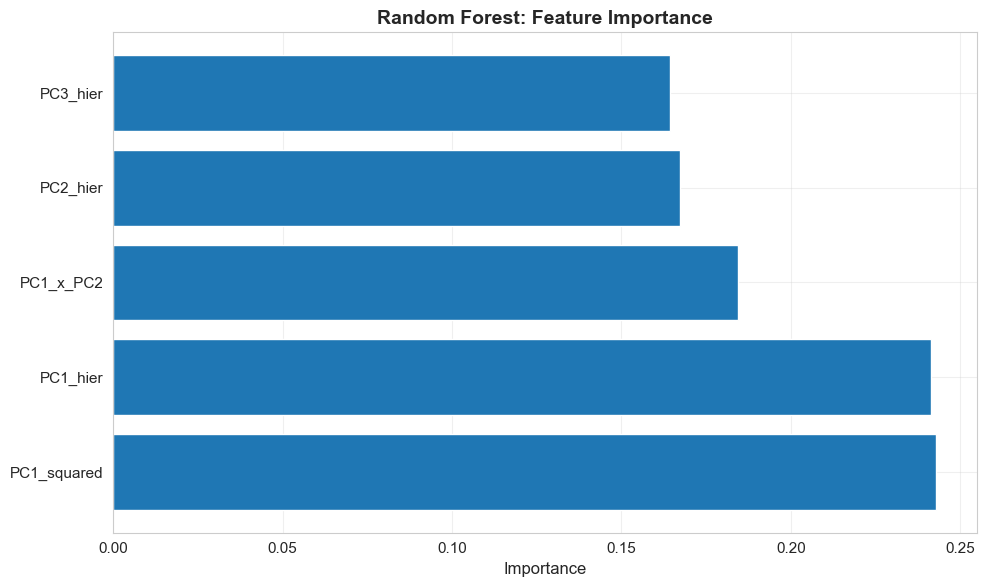

✓ Saved: figures/03_feature_importance.png


In [9]:
# Visualize feature importance
fig, ax = plt.subplots(figsize=(10, 6))
ax.barh(feature_importance_rf['Feature'], feature_importance_rf['Importance'])
ax.set_xlabel("Importance", fontsize=12)
ax.set_title("Random Forest: Feature Importance", fontsize=14, fontweight="bold")
ax.grid(alpha=0.3)
plt.tight_layout()
plt.savefig("figures/03_feature_importance.png", dpi=300, bbox_inches="tight")
plt.show()
print("✓ Saved: figures/03_feature_importance.png")

---
## 7. XGBoost Classifier (if available)

In [15]:
if XGBOOST_AVAILABLE:
    # Calculate scale_pos_weight for class imbalance
    scale_pos_weight = (y_train == 0).sum() / (y_train == 1).sum()
    
    # Train XGBoost
    xgb_clf = XGBClassifier(
        n_estimators=100,
        max_depth=3,
        learning_rate=0.1,
        scale_pos_weight=scale_pos_weight,
        random_state=42,
        eval_metric='logloss'
    )
    xgb_clf.fit(X_train, y_train)
    
    # Predictions
    y_pred_xgb = xgb_clf.predict(X_test)
    y_proba_xgb = xgb_clf.predict_proba(X_test)[:, 1]
    
    # Evaluate
    print("\n" + "="*80)
    print("XGBOOST RESULTS")
    print("="*80)
    print("\nClassification Report:")
    print(classification_report(y_test, y_pred_xgb, target_names=['Survived', 'Collapsed']))
    
    # ROC-AUC
    roc_auc_xgb = roc_auc_score(y_test, y_proba_xgb)
    print(f"\nROC-AUC Score: {roc_auc_xgb:.3f}")
else:
    print("⚠ XGBoost not available. Skipping.")
    roc_auc_xgb = None


XGBOOST RESULTS

Classification Report:
              precision    recall  f1-score   support

    Survived       0.79      0.85      0.81        13
   Collapsed       0.78      0.70      0.74        10

    accuracy                           0.78        23
   macro avg       0.78      0.77      0.78        23
weighted avg       0.78      0.78      0.78        23


ROC-AUC Score: 0.854


---
## 8. Model Comparison & ROC Curves

In [16]:
# Compare models
model_comparison = pd.DataFrame({
    'Model': ['Logistic Regression', 'Random Forest', 'XGBoost'],
    'ROC-AUC': [roc_auc_lr, roc_auc_rf, roc_auc_xgb if XGBOOST_AVAILABLE else np.nan]
})
model_comparison = model_comparison.sort_values('ROC-AUC', ascending=False)

print("\n" + "="*80)
print("MODEL COMPARISON")
print("="*80)
display(model_comparison)

print(f"\n→ Best model: {model_comparison.iloc[0]['Model']} (ROC-AUC = {model_comparison.iloc[0]['ROC-AUC']:.3f})")


MODEL COMPARISON


,Model,ROC-AUC
2,XGBoost,0.853846
1,Random Forest,0.838462
0,Logistic Regression,0.746154



→ Best model: XGBoost (ROC-AUC = 0.854)


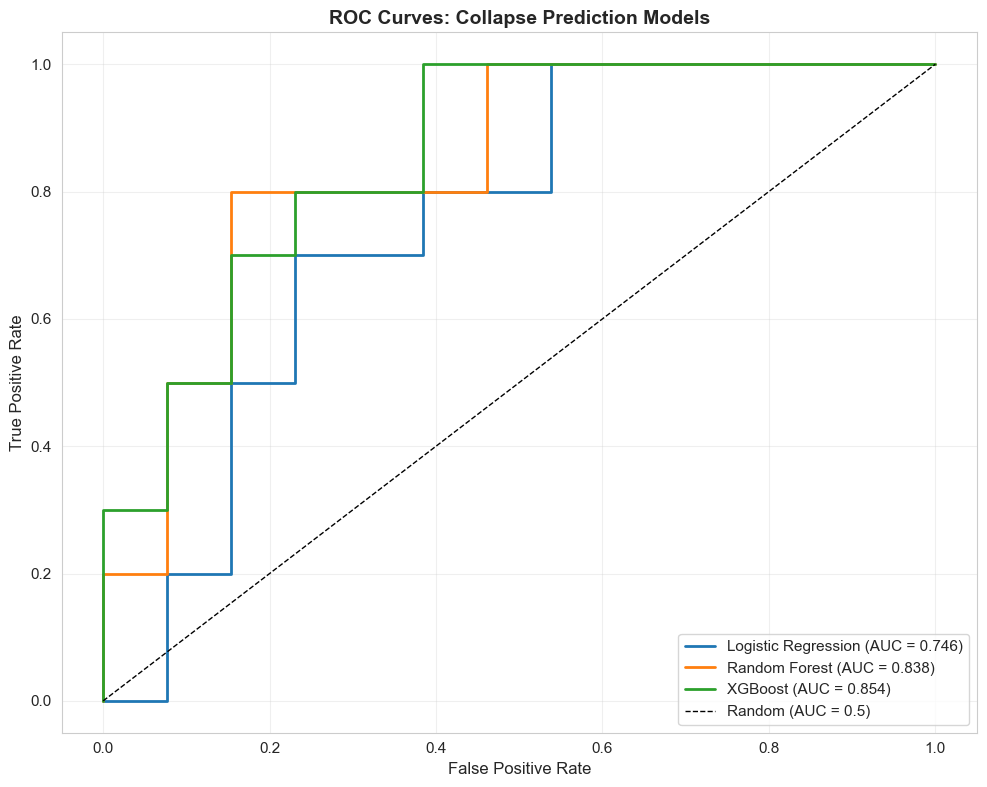

✓ Saved: figures/03_roc_curves.png


In [17]:
# Plot ROC curves
fig, ax = plt.subplots(figsize=(10, 8))

# Logistic Regression
fpr_lr, tpr_lr, _ = roc_curve(y_test, y_proba_lr)
ax.plot(fpr_lr, tpr_lr, linewidth=2, label=f'Logistic Regression (AUC = {roc_auc_lr:.3f})')

# Random Forest
fpr_rf, tpr_rf, _ = roc_curve(y_test, y_proba_rf)
ax.plot(fpr_rf, tpr_rf, linewidth=2, label=f'Random Forest (AUC = {roc_auc_rf:.3f})')

# XGBoost
if XGBOOST_AVAILABLE:
    fpr_xgb, tpr_xgb, _ = roc_curve(y_test, y_proba_xgb)
    ax.plot(fpr_xgb, tpr_xgb, linewidth=2, label=f'XGBoost (AUC = {roc_auc_xgb:.3f})')

# Diagonal (random classifier)
ax.plot([0, 1], [0, 1], 'k--', linewidth=1, label='Random (AUC = 0.5)')

ax.set_xlabel("False Positive Rate", fontsize=12)
ax.set_ylabel("True Positive Rate", fontsize=12)
ax.set_title("ROC Curves: Collapse Prediction Models", fontsize=14, fontweight="bold")
ax.legend(loc="lower right")
ax.grid(alpha=0.3)

plt.tight_layout()
plt.savefig("figures/03_roc_curves.png", dpi=300, bbox_inches="tight")
plt.show()
print("✓ Saved: figures/03_roc_curves.png")

---
## 9. Confusion Matrix

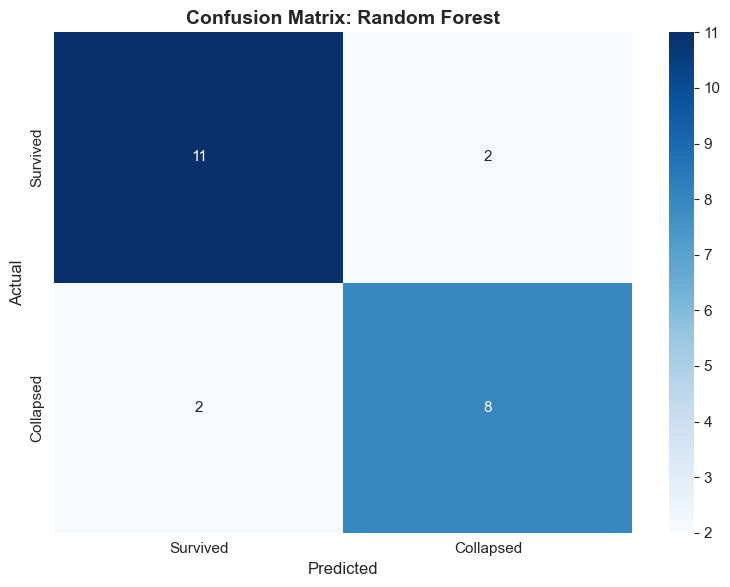

✓ Saved: figures/03_confusion_matrix.png


In [18]:
# Use best model (Random Forest for visualization)
cm = confusion_matrix(y_test, y_pred_rf)

fig, ax = plt.subplots(figsize=(8, 6))
sns.heatmap(cm, annot=True, fmt='d', cmap='Blues', 
            xticklabels=['Survived', 'Collapsed'],
            yticklabels=['Survived', 'Collapsed'],
            ax=ax)
ax.set_xlabel("Predicted", fontsize=12)
ax.set_ylabel("Actual", fontsize=12)
ax.set_title("Confusion Matrix: Random Forest", fontsize=14, fontweight="bold")

plt.tight_layout()
plt.savefig("figures/03_confusion_matrix.png", dpi=300, bbox_inches="tight")
plt.show()
print("✓ Saved: figures/03_confusion_matrix.png")

---
## 10. Summary & Insights

In [19]:
print("\n" + "="*80)
print(" " * 20 + "COLLAPSE PREDICTION: KEY FINDINGS")
print("="*80)

print(f"\n1. TASK DEFINITION")
print(f"   • Target: Polities with duration < {duration_median:.0f} years (median)")
print(f"   • Class balance: {(y == 1).mean():.1%} collapsed, {(y == 0).mean():.1%} survived")

print(f"\n2. BEST MODEL")
best_model = model_comparison.iloc[0]['Model']
best_auc = model_comparison.iloc[0]['ROC-AUC']
print(f"   • {best_model}")
print(f"   • ROC-AUC: {best_auc:.3f}")

print(f"\n3. MOST PREDICTIVE FEATURES")
for idx, row in feature_importance_rf.head(3).iterrows():
    print(f"   • {row['Feature']}: {row['Importance']:.3f}")

print(f"\n4. INTERPRETATION")
if feature_importance_rf.iloc[0]['Feature'] == 'PC1_hier':
    print(f"   • Social complexity (PC1) is the strongest predictor")
    if log_reg.coef_[0][0] > 0:
        print(f"   • Higher complexity → Higher collapse risk")
    else:
        print(f"   • Higher complexity → Lower collapse risk")

print(f"\n5. MODEL PERFORMANCE")
if best_auc > 0.7:
    print(f"   • Good predictive power (AUC > 0.7)")
elif best_auc > 0.6:
    print(f"   • Moderate predictive power (AUC = 0.6-0.7)")
else:
    print(f"   • Limited predictive power (AUC < 0.6)")
    print(f"   • More features or data may be needed")

print(f"\n6. LIMITATIONS")
print(f"   • Small dataset (n = {len(modeling_df)})")
print(f"   • Binary classification may oversimplify collapse dynamics")
print(f"   • No temporal information (static snapshot)")

print(f"\n7. NEXT STEPS")
print(f"   • Extract time-varying features (complexity trajectories)")
print(f"   • Survival analysis (time-to-event modeling)")
print(f"   • Integrate additional variables (warfare, climate, trade)")

print("\n" + "="*80)
print("✓ Collapse prediction analysis complete")
print("="*80)


                    COLLAPSE PREDICTION: KEY FINDINGS

1. TASK DEFINITION
   • Target: Polities with duration < 162 years (median)
   • Class balance: 45.6% collapsed, 54.4% survived

2. BEST MODEL
   • XGBoost
   • ROC-AUC: 0.854

3. MOST PREDICTIVE FEATURES
   • PC1_squared: 0.243
   • PC1_hier: 0.241
   • PC1_x_PC2: 0.184

4. INTERPRETATION

5. MODEL PERFORMANCE
   • Good predictive power (AUC > 0.7)

6. LIMITATIONS
   • Small dataset (n = 114)
   • Binary classification may oversimplify collapse dynamics
   • No temporal information (static snapshot)

7. NEXT STEPS
   • Extract time-varying features (complexity trajectories)
   • Survival analysis (time-to-event modeling)
   • Integrate additional variables (warfare, climate, trade)

✓ Collapse prediction analysis complete


---
## 11. Export Results

In [20]:
# Save model comparison
model_comparison.to_csv("models/collapse_model_comparison.csv", index=False)
print("✓ Saved: models/collapse_model_comparison.csv")

# Save feature importance
feature_importance_rf.to_csv("models/collapse_feature_importance.csv", index=False)
print("✓ Saved: models/collapse_feature_importance.csv")

# Save predictions
predictions_df = pd.DataFrame({
    'actual': y_test,
    'predicted_lr': y_pred_lr,
    'predicted_rf': y_pred_rf,
    'proba_rf': y_proba_rf
})
predictions_df.to_csv("models/collapse_predictions.csv", index=False)
print("✓ Saved: models/collapse_predictions.csv")

print("\n✓ All results exported")

✓ Saved: models/collapse_model_comparison.csv
✓ Saved: models/collapse_feature_importance.csv
✓ Saved: models/collapse_predictions.csv

✓ All results exported
